In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

'''
training_data = pd.read_csv('C:/Users/is_li/Desktop/paper/github/stock on MLOps/MLOps/tools/DVC/example/data/train.csv',
index_col= [0,1],header=[0,1])
valid_data = pd.read_csv('C:/Users/is_li/Desktop/paper/github/stock on MLOps/MLOps/tools/DVC/example/data/valid.csv',
index_col= [0,1],header=[0,1])
test_data = pd.read_csv('C:/Users/is_li/Desktop/paper/github/stock on MLOps/MLOps/tools/DVC/example/data/test.csv',
index_col= [0,1],header=[0,1])
'''
df_data  = pd.read_csv('C:/Users/is_li/Desktop/paper/github/stock on MLOps/MLOps/tools/DVC/example/data/dataset.csv',
index_col= [0,1],header=[0,1])

c:\ProgramData\Anaconda3\envs\py380\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
'''
df_data  =  df_data.dropna(subset=[('label', 'label')])
df_data =  df_data.dropna(axis=1,how='all')
df = df_data['feature'].dropna(axis=1,how='any')
df = df.dropna(axis=1,how='any')
'''


"\ndf_data  =  df_data.dropna(subset=[('label', 'label')])\ndf_data =  df_data.dropna(axis=1,how='all')\ndf = df_data['feature'].dropna(axis=1,how='any')\ndf = df.dropna(axis=1,how='any')\n"

In [3]:
df_data = df_data.fillna(0)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional	
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
"""
数据预处理

train_data = training_data#训练集
test_data = test_data#测试集
#将数据集转换为tensor，因为PyTorch模型是使用tensor进行训练的，并将训练数据转换为输入序列和相应的标签
train_data = torch.tensor(train_data.values).contiguous().view(-1)
train_data = train_data.to(torch.float32)
test_data = torch.tensor(test_data.values).contiguous().view(-1)
test_data= test_data.to(torch.float32)
"""
#划分测试集和训练集



'\n数据预处理\n\ntrain_data = training_data#训练集\ntest_data = test_data#测试集\n#将数据集转换为tensor，因为PyTorch模型是使用tensor进行训练的，并将训练数据转换为输入序列和相应的标签\ntrain_data = torch.tensor(train_data.values).contiguous().view(-1)\ntrain_data = train_data.to(torch.float32)\ntest_data = torch.tensor(test_data.values).contiguous().view(-1)\ntest_data= test_data.to(torch.float32)\n'

In [5]:

# 创建两个列表，用来存储数据的特征和标签
data_feat, data_target = [],[]

# 设每条数据序列有20组数据
seq = 10
feature_num = 10

for index in range(len(df_data) - seq):
    # 构建特征集
    data_feat.append(df_data['feature'].iloc[:,range(feature_num)][index: index + seq].values)
    # 构建target集
    data_target.append(df_data['label'][index:index + seq])

# 将特征集和标签集整理成numpy数组
data_feat = np.array(data_feat)
data_target = np.array(data_target)


In [6]:
# 这里按照8:2的比例划分训练集和测试集
test_set_size = int(np.round(0.1*df_data.shape[0]))  # np.round(1)是四舍五入，
train_size = data_feat.shape[0] - (test_set_size) 
print(test_set_size)  # 输出测试集大小
print(train_size)     # 输出训练集大小

611
5489


In [7]:

trainX = torch.from_numpy(data_feat[:train_size].reshape(-1,seq,feature_num)).type(torch.Tensor)   
# 这里第一个维度自动确定，我们认为其为batch_size，因为在LSTM类的定义中，设置了batch_first=True
testX  = torch.from_numpy(data_feat[train_size:].reshape(-1,seq,feature_num)).type(torch.Tensor)
trainY = torch.from_numpy(data_target[:train_size].reshape(-1,seq,1)).type(torch.Tensor)
testY  = torch.from_numpy(data_target[train_size:].reshape(-1,seq,1)).type(torch.Tensor)
print('x_train.shape = ',trainX.shape)
print('y_train.shape = ',trainY.shape)
print('x_test.shape = ',testX.shape)
print('y_test.shape = ',testY.shape)



x_train.shape =  torch.Size([5489, 10, 10])
y_train.shape =  torch.Size([5489, 10, 1])
x_test.shape =  torch.Size([611, 10, 10])
y_test.shape =  torch.Size([611, 10, 1])


In [8]:
batch_size=5
train = torch.utils.data.TensorDataset(trainX,trainY)
test = torch.utils.data.TensorDataset(testX,testY)
train_loader = torch.utils.data.DataLoader(dataset=train, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [9]:
import torch.nn as nn

input_dim = feature_num    # 数据的特征数
hidden_dim = 2    # 隐藏层的神经元个数
num_layers = 2     # LSTM的层数
output_dim = 1     # 预测值的特征数
                   #（这是预测股票价格，所以这里特征数是1，如果预测一个单词，那么这里是one-hot向量的编码长度）
class LSTM(nn.Module):
    """
        使用LSTM进行回归
        参数：
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, _x):
        x, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
        s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
        x = x.view(s * b, h)
        x = self.fc(x)
        x = x.view(s, b, -1)  # 把形状改回来
        return x

LSTM(
  (lstm): LSTM(10, 2, num_layers=2)
  (fc): Linear(in_features=2, out_features=1, bias=True)
)
torch.Size([8, 10])
torch.Size([8, 2])
torch.Size([8])
torch.Size([8])
torch.Size([8, 2])
torch.Size([8, 2])
torch.Size([8])
torch.Size([8])
torch.Size([1, 2])
torch.Size([1])
Epoch: 10, Loss:0.0041998122
Epoch: 20, Loss:0.0058934260
Epoch: 30, Loss:0.0034175829
Epoch: 40, Loss:0.0013559534
Epoch: 50, Loss:0.0007672827


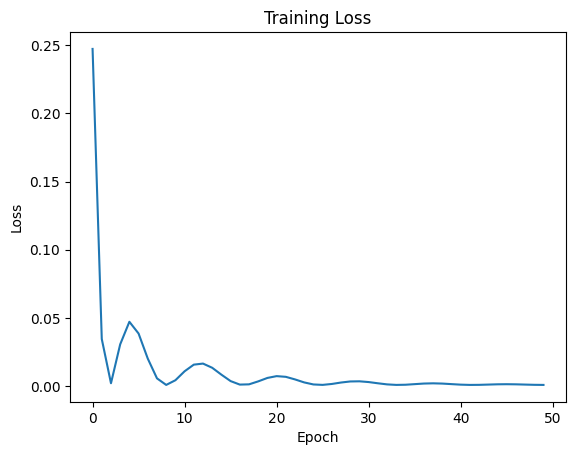

In [10]:
# 定义模型
num_epochs = 50
model = LSTM(input_size=input_dim, hidden_size=hidden_dim, output_size=output_dim, num_layers=num_layers)
# print(model)
# 打印模型各层的参数尺寸
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())
    
loss_function = nn.MSELoss()  # 损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # 优化器

train_loss = [] 
for epoch in range(num_epochs):
    out = model(trainX)
    loss = loss_function(out, trainY)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    train_loss.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print('Epoch: {}, Loss:{:.10f}'.format(epoch + 1, loss.item()))

plt.plot(train_loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()